In [37]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
import sklearn.preprocessing as prep
import sklearn.model_selection as ms
from functools import partial
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [38]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Data/FINAL/Final Data_Split/train_data(50%)_down.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Data/FINAL/Final Data_Split/test_data(50%)_down.csv")

####################################################################

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
###################################################################
# Down Sampling

# # n:1
# # train 데이터의 레이블 비율 확인
# train_labels = train_data['y']
# label_counts = train_labels.value_counts()

# # train 데이터의 레이블 비율이 n:1이 되도록 분할
# num_samples_class_0 = int(label_counts[1] * 1)  # 레이블 0을 레이블 1의 n배로 설정
# num_samples_class_1 = label_counts[1]  # 레이블 1의 모든 샘플 개수

# class_0_data = train_data[train_data['y'] == 0]
# class_1_data = train_data[train_data['y'] == 1]

# # 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# class_1_data = class_1_data.sample(num_samples_class_1, random_state=42)

# # 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
# class_0_data = class_0_data.sample(num_samples_class_0, random_state=42)

# # 선택한 데이터를 결합하여 최종 train 데이터 생성
# train_data = pd.concat([class_0_data, class_1_data])

###################################################################

# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("test shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (978, 147) 

test shape
 (457, 147) 

train value
 0    489
1    489
Name: y, dtype: int64
test value
 0    341
1    116
Name: y, dtype: int64


In [39]:
# test_data와 train_data의 칼럼 차이 확인
column_difference = set(X_train.columns) - set(X_test.columns)
print("칼럼 차이:", column_difference)

칼럼 차이: set()


In [40]:
def tuning_params(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 2000, step=50)
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0, step=0.1)
    max_depth = trial.suggest_categorical("max_depth", [3, 4, 5, 6, 7, 8, 9, 10])
    
    for train_, val_ in cv.kfold_split(folds):
        trainX = train_[features]
        trainY = train_[target]
        valX = val_[features]
        valY = val_[target]
        
        model = xgb.XGBClassifier(
            seed=1,
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor",
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            max_depth=max_depth,
            use_label_encoder=False,
            early_stopping_rounds=300, 
                 
        )
        
        model.fit(trainX, trainY, 
                   eval_set=[(valX, valY)],
                  verbose=False
                 )
    
        predY = model.predict(valX)
        val_f1 = f1_score(valY, predY)# Calculate F1-score
        return val_f1
    
        # val_auc = metrics.roc_auc_score(valY, predY)
        # return val_auc

In [41]:
class CrossValidation:
    def __init__(self, df, shuffle,random_state=None):
        self.df = df
        self.random_state = random_state
        self.shuffle = shuffle
        if shuffle is True:
            self.df = df.sample(frac=1,
                random_state=self.random_state).reset_index(drop=True)

    def hold_out_split(self,percent,stratify=None):
        if stratify is not None:
            y = self.df[stratify]
            train,val = ms.train_test_split(self.df, test_size=percent/100,
                stratify=y, random_state=self.random_state)
            return train,val
        size = len(self.df) - int(len(self.df)*(percent/100))
        train = self.df.iloc[:size,:]
        val = self.df.iloc[size:,:]
        return train,val

    def kfold_split(self, splits, stratify=None):
        if stratify is not None:
            kf = ms.StratifiedKFold(n_splits=splits,
                shuffle=self.shuffle,
                random_state=self.random_state)
            y = self.df[stratify]
            for train, val in kf.split(X=self.df,y=y):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t,v
        else:
            kf = ms.KFold(n_splits=splits, shuffle=self.shuffle,
                random_state=self.random_state)
            for train, val in kf.split(X=self.df):
                t = self.df.iloc[train,:]
                v = self.df.iloc[val, :]
                yield t,v

In [ ]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
model_list = []
auroc_list = []
    
for _ in range(10):

    model=xgb.XGBClassifier(seed=1,
                tree_method="gpu_hist",
                gpu_id=0,
                predictor="gpu_predictor",
                n_estimators=50)

    model.fit(X_train, y_train)
    y_pred2 = model.predict(X_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(train_data['y'], y_pred2)
    # print("Train Accuracy:", accuracy) 
    accuracy = accuracy_score(test_data['y'], y_pred)
    # print("Test Accuracy:", accuracy)

    seed = 42
    folds = 5
    cv = CrossValidation(train_data,
                         shuffle=True,
                         random_state=seed
                        )
    study = optuna.create_study(direction="maximize")
    study.optimize(tuning_params, n_trials=50, gc_after_trial=True)
    print(study.best_params)
    for train_, val_ in cv.kfold_split(folds):
            trainX = train_[features]
            trainY = train_[target]
            valX = val_[features]
            valY = val_[target]

            model = xgb.XGBClassifier(
                seed=1,
                tree_method="gpu_hist",
                gpu_id=0,
                predictor="gpu_predictor",
                n_estimators=study.best_params['n_estimators'],
                learning_rate=study.best_params['learning_rate'],
                reg_lambda=study.best_params['reg_lambda'],
                reg_alpha=study.best_params['reg_alpha'],
                subsample=study.best_params['subsample'],
                colsample_bytree=study.best_params['colsample_bytree'],
                max_depth=study.best_params['max_depth'],
                use_label_encoder=False,
            )
            model.fit(trainX,trainY,
                     early_stopping_rounds=300, 
                              eval_set=[(valX, valY)], verbose=False)

    y_pred2 = model.predict(X_train)
    y_pred = model.predict(X_test)
    


    # Precision, Recall, F1-score 계산
    precision = precision_score(test_data['y'], y_pred)
    recall = recall_score(test_data['y'], y_pred)
    f1 = f1_score(test_data['y'], y_pred)
    accuracy = accuracy_score(test_data['y'], y_pred)
    auroc = roc_auc_score(test_data['y'], y_pred)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    y_pred_list.append(y_pred)
    auroc_list.append(auroc)
    # model_list.append(model)
    
    
    
    print("Test Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("AUROC:", auroc)

[I 2023-09-28 19:08:37,862] A new study created in memory with name: no-name-b7e1afdf-4741-4963-bc7c-53eefb7eef86
[I 2023-09-28 19:08:41,168] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1050, 'learning_rate': 0.08152854099865946, 'reg_lambda': 0.0015123509748546243, 'reg_alpha': 57.9443975791942, 'subsample': 1.0, 'colsample_bytree': 0.30000000000000004, 'max_depth': 7}. Best is trial 0 with value: 0.0.
[I 2023-09-28 19:08:47,700] Trial 1 finished with value: 0.5913978494623656 and parameters: {'n_estimators': 500, 'learning_rate': 0.012283966509700777, 'reg_lambda': 5.163321642091082e-06, 'reg_alpha': 37.14151125848629, 'subsample': 0.9, 'colsample_bytree': 1.0, 'max_depth': 9}. Best is trial 1 with value: 0.5913978494623656.
[I 2023-09-28 19:08:52,244] Trial 2 finished with value: 0.6404494382022472 and parameters: {'n_estimators': 550, 'learning_rate': 0.20604952124339668, 'reg_lambda': 0.0038157346915537625, 'reg_alpha': 12.579775483749884, 'subsample': 0.7000

{'n_estimators': 1850, 'learning_rate': 0.017150895968556172, 'reg_lambda': 2.706133595725738e-07, 'reg_alpha': 0.004442970496550498, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'max_depth': 3}
Test Accuracy: 0.6214442013129103
Precision: 0.35678391959798994
Recall: 0.6120689655172413
F1-score: 0.4507936507936508
AUROC: 0.6183511983011427


[I 2023-09-28 19:15:27,438] A new study created in memory with name: no-name-05e3603e-a545-45a4-935c-f96b9b5c498c
[I 2023-09-28 19:15:37,542] Trial 0 finished with value: 0.6551724137931035 and parameters: {'n_estimators': 550, 'learning_rate': 0.010229478602145922, 'reg_lambda': 9.505429289872532e-08, 'reg_alpha': 1.5351129353990807e-07, 'subsample': 0.4, 'colsample_bytree': 1.0, 'max_depth': 7}. Best is trial 0 with value: 0.6551724137931035.
[I 2023-09-28 19:15:43,984] Trial 1 finished with value: 0.6783625730994153 and parameters: {'n_estimators': 300, 'learning_rate': 0.01423774167060718, 'reg_lambda': 0.001745877639377833, 'reg_alpha': 3.4148342404065314e-08, 'subsample': 0.9, 'colsample_bytree': 1.0, 'max_depth': 8}. Best is trial 1 with value: 0.6783625730994153.
[I 2023-09-28 19:15:54,796] Trial 2 finished with value: 0.616279069767442 and parameters: {'n_estimators': 800, 'learning_rate': 0.017256337906648954, 'reg_lambda': 2.615426809837149e-06, 'reg_alpha': 2.08372816775614

{'n_estimators': 600, 'learning_rate': 0.014023377511181288, 'reg_lambda': 0.00017177456427904385, 'reg_alpha': 0.008814557222413833, 'subsample': 0.5, 'colsample_bytree': 0.7000000000000001, 'max_depth': 8}
Test Accuracy: 0.6258205689277899
Precision: 0.35751295336787564
Recall: 0.5948275862068966
F1-score: 0.44660194174757284
AUROC: 0.6155956112852665


[I 2023-09-28 19:22:37,097] A new study created in memory with name: no-name-72f5ec37-2f26-4922-a6a7-5da2975c3564
[I 2023-09-28 19:22:48,915] Trial 0 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 1800, 'learning_rate': 0.012634714325659241, 'reg_lambda': 1.5546099658942905, 'reg_alpha': 0.0018805262311212107, 'subsample': 0.5, 'colsample_bytree': 1.0, 'max_depth': 9}. Best is trial 0 with value: 0.6666666666666667.
[I 2023-09-28 19:22:57,686] Trial 1 finished with value: 0.6745562130177515 and parameters: {'n_estimators': 950, 'learning_rate': 0.033563621894208195, 'reg_lambda': 15.872561362642642, 'reg_alpha': 0.9746267793701756, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'max_depth': 5}. Best is trial 1 with value: 0.6745562130177515.
[I 2023-09-28 19:23:08,187] Trial 2 finished with value: 0.6549707602339181 and parameters: {'n_estimators': 1650, 'learning_rate': 0.013775565746285256, 'reg_lambda': 1.3831034344701698, 'reg_alpha': 1.4971953

{'n_estimators': 1100, 'learning_rate': 0.02749433646273081, 'reg_lambda': 1.506283218013599e-08, 'reg_alpha': 9.516334245331311, 'subsample': 0.9, 'colsample_bytree': 0.1, 'max_depth': 7}
Test Accuracy: 0.6433260393873085
Precision: 0.37823834196891193
Recall: 0.6293103448275862
F1-score: 0.47249190938511326
AUROC: 0.6387020932349075


[I 2023-09-28 19:31:51,641] A new study created in memory with name: no-name-87f04104-73c8-4d60-bbc4-f213263cc625
[I 2023-09-28 19:31:58,996] Trial 0 finished with value: 0.6227544910179641 and parameters: {'n_estimators': 1300, 'learning_rate': 0.032161290393834606, 'reg_lambda': 0.05844276265715079, 'reg_alpha': 0.013074026854741527, 'subsample': 0.9, 'colsample_bytree': 0.2, 'max_depth': 6}. Best is trial 0 with value: 0.6227544910179641.
[I 2023-09-28 19:32:17,937] Trial 1 finished with value: 0.6590909090909091 and parameters: {'n_estimators': 1500, 'learning_rate': 0.02565252218581645, 'reg_lambda': 82.10190616958513, 'reg_alpha': 0.0043139054253103085, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'max_depth': 3}. Best is trial 1 with value: 0.6590909090909091.
[I 2023-09-28 19:32:27,143] Trial 2 finished with value: 0.64 and parameters: {'n_estimators': 1400, 'learning_rate': 0.020687624591865975, 'reg_lambda': 0.9755967186115584, 'reg_alpha': 1.9835

{'n_estimators': 900, 'learning_rate': 0.025908447898680784, 'reg_lambda': 0.08452103271273909, 'reg_alpha': 0.03363298647123844, 'subsample': 0.6, 'colsample_bytree': 0.30000000000000004, 'max_depth': 9}
Test Accuracy: 0.6323851203501094
Precision: 0.3631578947368421
Recall: 0.5948275862068966
F1-score: 0.45098039215686275
AUROC: 0.6199944382647385


[I 2023-09-28 19:39:49,719] A new study created in memory with name: no-name-5251773b-7d6e-4b64-a239-4b08f30ac044
[I 2023-09-28 19:39:55,790] Trial 0 finished with value: 0.6190476190476192 and parameters: {'n_estimators': 1200, 'learning_rate': 0.08980048976171016, 'reg_lambda': 2.7564219867286553e-07, 'reg_alpha': 0.03869408080470381, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001, 'max_depth': 7}. Best is trial 0 with value: 0.6190476190476192.
[I 2023-09-28 19:40:01,080] Trial 1 finished with value: 0.6250000000000001 and parameters: {'n_estimators': 850, 'learning_rate': 0.12944523501054775, 'reg_lambda': 0.0010709990937024844, 'reg_alpha': 2.7929897086937254e-08, 'subsample': 1.0, 'colsample_bytree': 0.5, 'max_depth': 7}. Best is trial 1 with value: 0.6250000000000001.
[I 2023-09-28 19:40:08,953] Trial 2 finished with value: 0.6585365853658536 and parameters: {'n_estimators': 400, 'learning_rate': 0.02325006494382407, 'reg_lambda': 5.778804069737053e-06, 'reg_alpha': 0.

{'n_estimators': 1600, 'learning_rate': 0.059412695088438085, 'reg_lambda': 80.49194863463381, 'reg_alpha': 0.0001296412748546414, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.1, 'max_depth': 8}
Test Accuracy: 0.6083150984682714
Precision: 0.3448275862068966
Recall: 0.603448275862069
F1-score: 0.438871473354232
AUROC: 0.6067094751744362


[I 2023-09-28 19:48:41,434] A new study created in memory with name: no-name-5faa0566-93de-40ab-9e25-9197b170432c
[I 2023-09-28 19:48:46,013] Trial 0 finished with value: 0.5747126436781608 and parameters: {'n_estimators': 1250, 'learning_rate': 0.15546092772121586, 'reg_lambda': 2.0279066271691218e-08, 'reg_alpha': 1.7090840179506768e-05, 'subsample': 0.5, 'colsample_bytree': 0.9, 'max_depth': 8}. Best is trial 0 with value: 0.5747126436781608.
[I 2023-09-28 19:48:47,865] Trial 1 finished with value: 0.6071428571428571 and parameters: {'n_estimators': 100, 'learning_rate': 0.025478932942500174, 'reg_lambda': 2.01635952535128e-06, 'reg_alpha': 0.0009591732524062004, 'subsample': 0.2, 'colsample_bytree': 0.2, 'max_depth': 5}. Best is trial 1 with value: 0.6071428571428571.
[I 2023-09-28 19:48:54,571] Trial 2 finished with value: 0.5930232558139535 and parameters: {'n_estimators': 900, 'learning_rate': 0.03956632655676502, 'reg_lambda': 3.6613404386358875e-05, 'reg_alpha': 1.814445101596

{'n_estimators': 2000, 'learning_rate': 0.011323698417998176, 'reg_lambda': 2.2792644561266426e-05, 'reg_alpha': 4.6479660630608155e-08, 'subsample': 0.6, 'colsample_bytree': 0.5, 'max_depth': 7}
Test Accuracy: 0.6214442013129103
Precision: 0.35233160621761656
Recall: 0.5862068965517241
F1-score: 0.4401294498381877
AUROC: 0.6098189907978562


[I 2023-09-28 19:56:16,352] A new study created in memory with name: no-name-11a5c3fb-85c3-4531-9dc7-572ea05b5a12
[I 2023-09-28 19:56:19,739] Trial 0 finished with value: 0.6022727272727273 and parameters: {'n_estimators': 200, 'learning_rate': 0.021992053955612396, 'reg_lambda': 0.25480532886530555, 'reg_alpha': 0.0005025492495132957, 'subsample': 0.1, 'colsample_bytree': 0.8, 'max_depth': 9}. Best is trial 0 with value: 0.6022727272727273.
[I 2023-09-28 19:56:28,643] Trial 1 finished with value: 0.6514285714285715 and parameters: {'n_estimators': 1400, 'learning_rate': 0.05054008692153485, 'reg_lambda': 0.26343647439762785, 'reg_alpha': 4.534288633884587, 'subsample': 0.5, 'colsample_bytree': 0.7000000000000001, 'max_depth': 9}. Best is trial 1 with value: 0.6514285714285715.
[I 2023-09-28 19:56:35,341] Trial 2 finished with value: 0.6705202312138728 and parameters: {'n_estimators': 350, 'learning_rate': 0.04455709966780802, 'reg_lambda': 1.0169870212446546e-07, 'reg_alpha': 0.088246

{'n_estimators': 550, 'learning_rate': 0.1949306497560025, 'reg_lambda': 3.575206099083247e-08, 'reg_alpha': 17.92834863357747, 'subsample': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3}
Test Accuracy: 0.6192560175054704
Precision: 0.3473684210526316
Recall: 0.5689655172413793
F1-score: 0.43137254901960786
AUROC: 0.6026645768025078


[I 2023-09-28 20:00:59,965] A new study created in memory with name: no-name-0c0d2e66-ec7b-47d8-873e-33843b505435
[I 2023-09-28 20:01:06,236] Trial 0 finished with value: 0.6285714285714286 and parameters: {'n_estimators': 400, 'learning_rate': 0.0504003906811651, 'reg_lambda': 1.2622091626195427e-07, 'reg_alpha': 2.096431369976559, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6, 'max_depth': 5}. Best is trial 0 with value: 0.6285714285714286.
[I 2023-09-28 20:01:13,003] Trial 1 finished with value: 0.6704545454545455 and parameters: {'n_estimators': 600, 'learning_rate': 0.02705406120502871, 'reg_lambda': 2.9093535933864547e-06, 'reg_alpha': 6.524928011885994e-08, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'max_depth': 6}. Best is trial 1 with value: 0.6704545454545455.
[I 2023-09-28 20:01:22,870] Trial 2 finished with value: 0.6347305389221557 and parameters: {'n_estimators': 1300, 'learning_rate': 0.019852792526720613, 'reg_lambda': 1.0416807

{'n_estimators': 1250, 'learning_rate': 0.01001770474200732, 'reg_lambda': 33.8389501258834, 'reg_alpha': 6.214237883855341e-06, 'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 6}
Test Accuracy: 0.6323851203501094
Precision: 0.3673469387755102
Recall: 0.6206896551724138
F1-score: 0.4615384615384615
AUROC: 0.6285266457680251


[I 2023-09-28 20:09:59,505] A new study created in memory with name: no-name-e1430b7c-e871-4aad-8e5a-32d3611c30ae
[I 2023-09-28 20:09:59,926] Trial 0 finished with value: 0.6516853932584269 and parameters: {'n_estimators': 100, 'learning_rate': 0.0848196116038487, 'reg_lambda': 29.88657077022029, 'reg_alpha': 0.0038164983939987505, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1, 'max_depth': 7}. Best is trial 0 with value: 0.6516853932584269.
[I 2023-09-28 20:10:00,973] Trial 1 finished with value: 0.6627906976744186 and parameters: {'n_estimators': 1500, 'learning_rate': 0.029755048235165824, 'reg_lambda': 3.730408748602313e-06, 'reg_alpha': 1.0226612249116935e-06, 'subsample': 0.9, 'colsample_bytree': 0.7000000000000001, 'max_depth': 5}. Best is trial 1 with value: 0.6627906976744186.
[I 2023-09-28 20:10:01,863] Trial 2 finished with value: 0.6227544910179641 and parameters: {'n_estimators': 400, 'learning_rate': 0.1279423865768806, 'reg_lambda': 6.309579954785366e-05, 'reg

{'n_estimators': 100, 'learning_rate': 0.0397981924321949, 'reg_lambda': 0.13676617843362612, 'reg_alpha': 0.00016960095788856694, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'max_depth': 3}
Test Accuracy: 0.6301969365426696
Precision: 0.3626943005181347
Recall: 0.603448275862069
F1-score: 0.45307443365695793
AUROC: 0.6213722317726766


[I 2023-09-28 20:10:55,802] A new study created in memory with name: no-name-ee5e5ca0-235d-4818-ab13-634d732fc5d4
[I 2023-09-28 20:10:56,403] Trial 0 finished with value: 0.5263157894736842 and parameters: {'n_estimators': 350, 'learning_rate': 0.06317341936723793, 'reg_lambda': 0.0392451139546883, 'reg_alpha': 53.21683591769111, 'subsample': 1.0, 'colsample_bytree': 0.2, 'max_depth': 7}. Best is trial 0 with value: 0.5263157894736842.
[I 2023-09-28 20:10:57,549] Trial 1 finished with value: 0.6820809248554912 and parameters: {'n_estimators': 300, 'learning_rate': 0.04333854304861548, 'reg_lambda': 51.16047310824855, 'reg_alpha': 0.027568733789587605, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.4, 'max_depth': 9}. Best is trial 1 with value: 0.6820809248554912.
[I 2023-09-28 20:10:58,518] Trial 2 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 750, 'learning_rate': 0.19873178453797008, 'reg_lambda': 2.0421231131301443e-06, 'reg_alpha': 0.386460015046

In [ ]:
print("finish")

In [ ]:
import matplotlib.pyplot as plt

# 박스 플롯 그리기
data = [accuracy_list, precision_list, recall_list, f1_list, auroc_list]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Evaluation Metrics')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [19]:
# 그리고 싶은 confusion matrix index
idx = 1 

cm = confusion_matrix(test_data['y'], y_pred_list[idx])

# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 그리기
precision, recall, _ = precision_recall_curve(test_data['y'], y_pred)
average_precision = average_precision_score(test_data['y'], y_pred)
area_under_curve = auc(recall, precision)

# Precision-Recall Curve 시각화
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()


NameError: name 'y_pred_list' is not defined

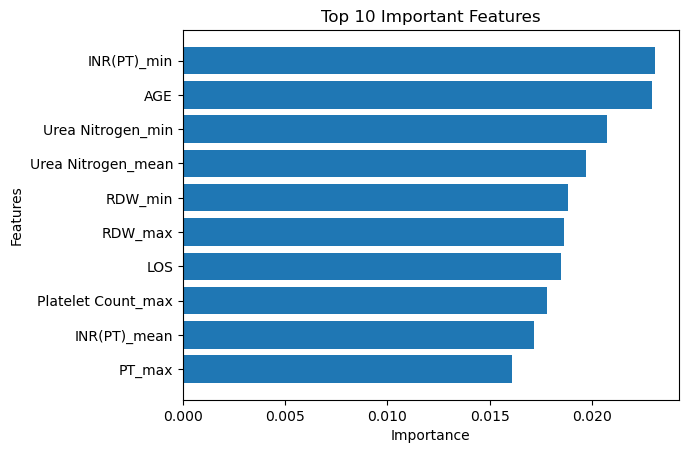

In [46]:
# 그리고 싶은 confusion matrix index
idx2 = 1 

feature_importance = model_list[idx2].feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a dictionary to store feature importance values and names
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importance)}

# Sort the feature importance dictionary by importance values in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 important features
top_10_features = sorted_feature_importance[:10]

# Extract feature names and importance values from the top 10 features
top_10_feature_names = [feature[0] for feature in top_10_features]
top_10_feature_importance = [feature[1] for feature in top_10_features]

# Invert the lists to reverse the order
top_10_feature_names.reverse()
top_10_feature_importance.reverse()

# Create a bar plot for the top 10 important features
plt.barh(top_10_feature_names, top_10_feature_importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.show()

In [47]:
data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'AUROC' : auroc_list,
    'Predictions': y_pred_list
}

# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(data)
df

,Accuracy,Precision,Recall,F1 Score,Predictions
0,0.719178,0.396552,0.793103,0.528736,"[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,0.684932,0.365079,0.793103,0.500000,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, ..."
2,0.678082,0.344828,0.689655,0.459770,"[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
3,0.691781,0.362069,0.724138,0.482759,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, ..."
4,0.698630,0.372881,0.758621,0.500000,"[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
5,0.650685,0.333333,0.758621,0.463158,"[1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, ..."
6,0.684932,0.355932,0.724138,0.477273,"[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
7,0.678082,0.350000,0.724138,0.471910,"[1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, ..."
8,0.671233,0.349206,0.758621,0.478261,"[1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
9,0.657534,0.327869,0.689655,0.444444,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, ..."


In [ ]:
# 적용할 열(칼럼) 목록 지정
columns_to_process = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC']

# 지정한 열(칼럼)에 대해 100을 곱하고 소수점 둘째 자리까지만 남기기
df[columns_to_process] = df[columns_to_process].apply(lambda x: (x * 100).round(2))


In [48]:
# DataFrame을 CSV 파일로 저장
df.to_csv('~/project/MIMIC-III/Model/Output/XGB/XGB_down(50%).csv', index=False)  # index를 저장하지 않으려면 index=False로 설정
